## Test Naive Bayes (Fake vs Real news) model generalisation

## Adopted the notebook of Victoria for generalisation

News Articles dataset
https://www.kaggle.com/datasets/ruchi798/source-based-news-classification

### Import libraries

In [1]:
import pandas as pd # data processing 
import matplotlib.pyplot as plt # plotting 
import numpy as np # linear algebra 
import seaborn as sns 

# tool to read data csv file (it is faster than pandas and can read files from .zip)
# import datatable as dt

import kaggle

# colored output text
from termcolor import colored

import re
import string 

from bs4 import BeautifulSoup

# from wordcloud import WordCloud, STOPWORDS

# module implements binary protocols for serializing and de-serializing a Python object
import pickle

# natural language toolkit (https://realpython.com/nltk-nlp-python/)
# (https://www.geeksforgeeks.org/python-lemmatization-approaches-with-examples/)
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')

# filter common words
from nltk.corpus import stopwords
# split text into words
from nltk.tokenize import word_tokenize
# nltk.download('averaged_perceptron_tagger')

# reduce words to their root by transformin to initial form with ectual meaning (ex. goes -> go )
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
# nltk.download('omw-1.4')

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

from sklearn.linear_model import LogisticRegression

# Silent warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

#for count vectorizer and naive bayes model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.feature_extraction import text


### Search for datasets

In [2]:
# search for the dataset
# !kaggle datasets list -s 'fake-tweets'

### Dowload datasets

In [3]:
# # https://www.kaggle.com/datasets/ruchi798/source-based-news-classification
# !kaggle datasets download 


In [4]:
# !mv source-based-news-classification.zip data

### Read dataset

In [5]:
raw_df = pd.read_csv('news_articles.csv')
raw_df.head()

,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1.0
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,1.0


### Drop redundant features

In [6]:
df = raw_df[['text', 'label']].copy()
df.head()

,text,label
0,print they should pay all the back all the mon...,Real
1,why did attorney general loretta lynch plead t...,Real
2,red state \nfox news sunday reported this mor...,Real
3,email kayla mueller was a prisoner and torture...,Real
4,email healthcare reform to make america great ...,Real


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2096 entries, 0 to 2095
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2050 non-null   object
 1   label   2095 non-null   object
dtypes: object(2)
memory usage: 32.9+ KB


In [8]:
#real tweets = 1, fake = 0
df.groupby('label').count()

,text
label,
Fake,1292
Real,758


In [9]:
df.isnull().sum()

text     46
label     1
dtype: int64

In [10]:
df['label'].replace({'Real': 1, 'Fake': 0}, inplace=True)
df.head()

,text,label
0,print they should pay all the back all the mon...,1.0
1,why did attorney general loretta lynch plead t...,1.0
2,red state \nfox news sunday reported this mor...,1.0
3,email kayla mueller was a prisoner and torture...,1.0
4,email healthcare reform to make america great ...,1.0


In [11]:
df.isnull().sum()

text     46
label     1
dtype: int64

In [12]:
df.dropna(subset=['label'], inplace=True)

In [13]:
df['label'].replace({'Real': 1, 'Fake': 0}, inplace=True)
df.head()

,text,label
0,print they should pay all the back all the mon...,1.0
1,why did attorney general loretta lynch plead t...,1.0
2,red state \nfox news sunday reported this mor...,1.0
3,email kayla mueller was a prisoner and torture...,1.0
4,email healthcare reform to make america great ...,1.0


In [14]:
df.isna().sum()

text     45
label     0
dtype: int64

### Plot label count

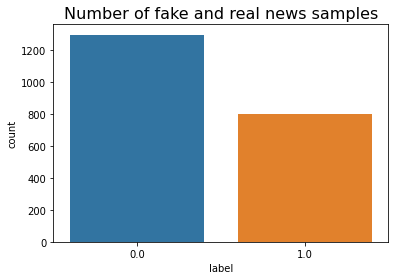

In [15]:
sns.countplot(x='label', data=df)
plt.title('Number of fake and real news samples', fontdict={'fontsize':16})
plt.show()

### Create function to clean data

In [16]:
# Function to remove HTML tags
def remove_tags(text):
  
    # parse html content
    soup = BeautifulSoup(text, "html.parser")
  
    for data in soup(['style', 'script']):
        # Remove tags
        data.decompose()
  
    # return data by retrieving the tag content
    return ' '.join(soup.stripped_strings)

In [17]:
df['text'] = df['text'].map(lambda x: remove_tags(str(x)))


In [18]:
# casefold
raw_df['text'] = raw_df['text'].map(lambda x: str(x).casefold())

In [19]:
def remove_punctuation_spec_char(text_):
    punctuation = string.punctuation
    text_ = ' '.join([word for word in text_.split() if word not in punctuation])
    text_ = ' '.join([re.sub(r'[^a-zA-Z]','',word) for word in text_.split()])
    return text_

df['text'] = df['text'].map(lambda x: remove_punctuation_spec_char(x))

In [20]:

df.head()

,text,label
0,print they should pay all the back all the mon...,1.0
1,why did attorney general loretta lynch plead t...,1.0
2,red state fox news sunday reported this mornin...,1.0
3,email kayla mueller was a prisoner and torture...,1.0
4,email healthcare reform to make america great ...,1.0


### Wordcloud plot

In [21]:
# fake_ = df.text[df['label']==0]
# real_ = df.text[df['label']==1]

# def plot_fake_vs_real(fake, real):
#     wordcloud_fake = WordCloud(width = 2000, height = 1300,
#                               background_color = 'white', 
#                               stopwords = STOPWORDS).generate(str(fake))
#     wordcloud_real = WordCloud(width = 2000, height = 1300,
#                               background_color = 'white', 
#                               stopwords = STOPWORDS).generate(str(real))
    
#     # plot WordCloud img 
#     plt.subplots(figsize=(15,6))
    
#     plt.subplot(1,3,1)
#     plt.imshow(wordcloud_fake, interpolation = 'bilinear')
#     plt.axis('off')
#     plt.tight_layout(pad=0)
    
#     plt.suptitle("Fake(left) vs Real(right)", y=0.5, va='center', size = 24)
    
#     plt.subplot(1,3,3)
#     plt.imshow(wordcloud_real, interpolation = 'bilinear')
#     plt.axis('off')
#     plt.tight_layout(pad=0)

    
# plot_fake_vs_real(fake_, real_)
# plt.show()      

### Save cleaned dataset

In [22]:
df = df[['text', 'label']].copy()
df.to_csv('cleaned_other_data.csv', index=False, encoding='utf-8')

### Load cleaned dataset

In [23]:
test_df = pd.read_csv('cleaned_other_data.csv')
test_df.head()

,text,label
0,print they should pay all the back all the mon...,1.0
1,why did attorney general loretta lynch plead t...,1.0
2,red state fox news sunday reported this mornin...,1.0
3,email kayla mueller was a prisoner and torture...,1.0
4,email healthcare reform to make america great ...,1.0


### Preprocess (remove stopwords, tag, lemmatize) 

In [24]:
# simplifies position of speech tags

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None


def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemma = WordNetLemmatizer()
 
    # tokenize text into words, clean of punctuation and stopwords
    text = word_tokenize(text)
    text = [word for word in text if word not in stop_words]  

    # tokenize text including position of speech
    text = nltk.pos_tag(text)   
    text = list(map(lambda x: (x[0], pos_tagger(x[1])), text))

    # lemmatize words with respect to position of speech
    text_ = []    
    for word, tag in text:
        if tag is None:
            text_.append(word)
        else:
            text_.append(lemma.lemmatize(word, tag))
    text = ' '.join(text_) 
    return text

In [25]:
test_df['text'] = test_df['text'].astype(str)
test_df['text']= test_df['text'].apply(preprocess_text)
test_df.head()

,text,label
0,print pay back money plus interest entire fami...,1.0
1,attorney general loretta lynch plead fifth bar...,1.0
2,red state fox news sunday report morning antho...,1.0
3,email kayla mueller prisoner torture isi chanc...,1.0
4,email healthcare reform make america great sin...,1.0


### Separate dependent variable

In [26]:
X = test_df['text'].values
y = test_df['label'].values

# X.shape, y.shape

### Vectorize data

In [27]:
# load vectorizer from pickle file (previously fitted on train data)
with open('CountVectorizer.pkl', 'rb') as file:
    vectorizer = pickle.load(file)
    
# transform data
all_words = vectorizer.fit_transform(df.text.values.astype('U'))

In [28]:
all_words.shape   


(2095, 46931)

In [29]:
vectorizer.vocabulary_


{'print': 32428,
 'pay': 30484,
 'money': 26955,
 'plus': 31502,
 'entire': 13410,
 'family': 14707,
 'came': 6022,
 'need': 27885,
 'deported': 10603,
 'asap': 2493,
 'did': 11019,
 'years': 46532,
 'bust': 5816,
 'group': 17878,
 'stealing': 39664,
 'government': 17558,
 'taxpayers': 41199,
 'somalis': 38775,
 'stole': 39855,
 'million': 26456,
 'benefits': 4052,
 'just': 22461,
 'months': 27020,
 'weve': 45627,
 'reported': 34785,
 'numerous': 28783,
 'cases': 6374,
 'like': 24215,
 'muslim': 27452,
 'refugeesimmigrants': 34327,
 'commit': 7955,
 'fraud': 16107,
 'scamming': 36470,
 'systemits': 40913,
 'way': 45302,
 'control': 8698,
 'related': 34523,
 'attorney': 2809,
 'general': 16858,
 'loretta': 24606,
 'lynch': 24845,
 'plead': 31435,
 'fifth': 15202,
 'barracuda': 3576,
 'brigade': 5385,
 'administration': 532,
 'blocking': 4746,
 'congressional': 8363,
 'probe': 32502,
 'cash': 6377,
 'payments': 30497,
 'iran': 21605,
 'course': 9062,
 'needs': 27897,
 'th': 41540,
 'reca

In [30]:
label=df["label"]  #renaming for better readability

In [31]:
x_train, x_test, y_train, y_test = train_test_split(all_words, label, test_size=0.2, random_state=75)

### Predict fake vs real news using pretrained Logistic Regression model

In [32]:
# load trained algorithm
with open('MultinomialNB.pkl', 'rb') as file:
    MultinomialNB = pickle.load(file)

In [33]:
classifier = MultinomialNB()

In [34]:
classifier.fit(x_train, y_train) #training the model with our CV-d text data and labels

MultinomialNB()

### Print classification report 

In [35]:
print(classification_report(y_test, classifier.predict(x_test)))

              precision    recall  f1-score   support

         0.0       0.81      0.65      0.72       272
         1.0       0.53      0.71      0.61       147

    accuracy                           0.68       419
   macro avg       0.67      0.68      0.67       419
weighted avg       0.71      0.68      0.68       419



### Plot confusion matrix

<AxesSubplot:>

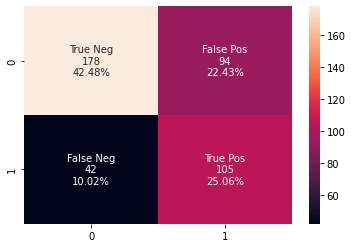

In [36]:
cm = confusion_matrix(y_test, classifier.predict(x_test))

sns.set_palette(palette='flare')

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt="")

### Plot Receiver operating characteristic (ROC) curve

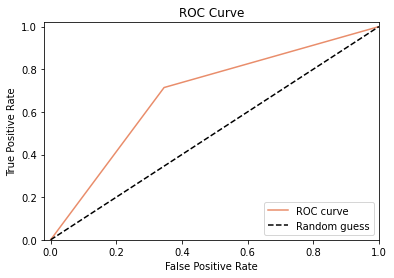

In [37]:
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict(x_test))
# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")